In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)
        
# make sure kaggle.json exists in at the root. ~/.kaggle/kaggle.json
# {"username":"xxx","key":"xxx"}

In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [3]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
df.isna()
# sum of all the NaN columns
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
modes = df.mode().iloc[0]
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [6]:
df.mode().iloc[0]

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
import numpy as np

df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


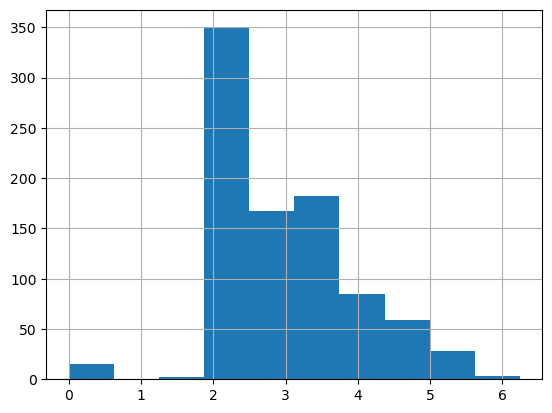

In [8]:
df['LogFare'] = np.log(df['Fare']+1)
df['LogFare'].hist();

In [9]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [10]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [11]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [12]:
added_cols = df.columns[10:].to_list()
df[added_cols].head()

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,0,1,0,0,1
1,1,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,0,1,0,0,0,0,1
4,0,1,0,0,1,0,0,1


In [13]:
from torch import tensor

t_dep = tensor(df.Survived)

In [14]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [15]:
len(t_indep.shape)

2

In [16]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
n_coeff

12

In [17]:
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [18]:
t_indep * coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.0000,  -0.3147,   0.0000

In [19]:
vals,indices = t_indep.max(dim=0)
vals

tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])

In [21]:
t_indep = t_indep / vals
t_indep

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

In [22]:
t_indep * coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [23]:
preds =  (t_indep * coeffs).sum(axis=1)
preds

tensor([     0.1412,     -0.5725,      0.1494,      0.2571,      0.0453,     -0.0448,      0.0792,      0.2961,      0.2128,     -0.5770,
             0.3093,      0.1311,      0.1321,      0.1942,      0.2191,     -0.0081,      0.1499,      0.1269,      0.1104,     -0.6378,
             0.0394,      0.0690,      0.0604,      0.2430,      0.3128,      0.2513,     -0.6892,      0.3557,      0.0089,      0.1096,
            -0.6194,     -0.5173,      0.0095,     -0.1090,     -0.5712,      0.1658,     -0.6892,      0.1263,      0.2029,     -0.5770,
             0.0799,      0.1619,     -0.6921,     -0.4445,      0.0379,      0.1090,     -0.0477,      0.0095,     -0.6913,      0.1860,
             0.2623,      0.1274,     -0.6388,      0.1429,     -0.7523,      0.2662,      0.2028,     -0.7153,      0.3598,      0.2907,
            -0.6777,      0.2078,      0.1316,      0.3149,     -0.5268,     -0.6564,      0.1565,      0.1375,      0.3511,      0.1297,
             0.0877,      0.3133, 

In [24]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5200)

In [25]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

# Doing a Gradient decent step

In [27]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [29]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5200, grad_fn=<MeanBackward0>)

In [30]:
loss.backward()

In [31]:
coeffs.grad

tensor([-0.0483,  0.0118, -0.0041, -0.0804, -0.1975,  0.1111, -0.1235, -0.0426,  0.0797, -0.1886, -0.0617,  0.1639])

In [32]:
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5056)


In [33]:
from fastai.data.transforms import RandomSplitter
trn_split, val_split = RandomSplitter(seed=42)(df)

In [35]:
len(trn_split), len(val_split)

(713, 178)

In [37]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]


In [39]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs, lr=lr)
    return coeffs


In [45]:
coeffs = train_model(18, lr=0.02)
coeffs
indep_cols

0.518; 0.515; 0.510; 0.501; 0.491; 0.480; 0.467; 0.453; 0.435; 0.411; 0.388; 0.366; 0.346; 0.328; 0.310; 0.295; 0.288; 0.298; 

['Age',
 'SibSp',
 'Parch',
 'LogFare',
 'Sex_female',
 'Sex_male',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [44]:
def show_coeffs():
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2206),
 'SibSp': tensor(0.1000),
 'Parch': tensor(0.2525),
 'LogFare': tensor(0.1055),
 'Sex_female': tensor(0.3394),
 'Sex_male': tensor(-0.4260),
 'Pclass_1': tensor(0.8616),
 'Pclass_2': tensor(0.4278),
 'Pclass_3': tensor(0.2830),
 'Embarked_C': tensor(0.1840),
 'Embarked_Q': tensor(0.3343),
 'Embarked_S': tensor(0.1067)}

# Measuring accuracy

In [46]:
preds = calc_preds(coeffs, val_indep)


In [47]:
results = val_dep.bool() == (preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [48]:
results.float().mean()

tensor(0.7921)

In [50]:
def acc(coeffs): return (val_dep.bool() == (calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7921)

# Using sigmoid

In [51]:
preds[:28]

tensor([ 1.0792,  0.1617,  0.0105,  0.1318,  0.0842,  0.0796,  0.8826,  0.8414,  0.1731,  0.8481, -0.0875,  0.0766,  0.0495,  0.9274,
        -0.0960,  0.4743,  0.4191,  0.9029,  0.0568,  0.6821, -0.0655,  0.4440,  1.4118,  0.9092, -0.0562,  0.1921,  0.8232,  0.4274],
       grad_fn=<SliceBackward0>)

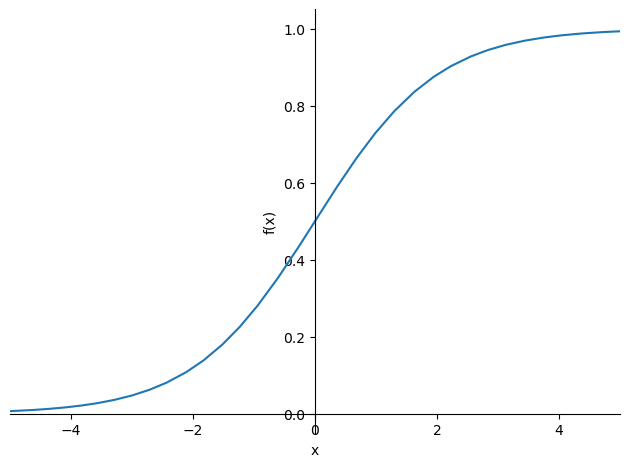

In [56]:
import sympy
sympy.plot('1/(1+exp(-x))', xlim=(-5, 5))

In [57]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))
coeffs = train_model(lr=2)

0.503; 0.461; 0.391; 0.336; 0.306; 0.285; 0.265; 0.245; 0.228; 0.217; 0.210; 0.206; 0.205; 0.204; 0.204; 0.204; 0.204; 0.205; 0.205; 0.205; 0.205; 0.204; 0.204; 0.203; 0.202; 0.201; 0.200; 0.199; 0.197; 0.196; 

In [58]:
acc(coeffs)

tensor(0.8258)

In [59]:
show_coeffs()

{'Age': tensor(-1.6580),
 'SibSp': tensor(-1.2331),
 'Parch': tensor(-0.0658),
 'LogFare': tensor(1.9805),
 'Sex_female': tensor(16.4337),
 'Sex_male': tensor(-18.8047),
 'Pclass_1': tensor(7.7292),
 'Pclass_2': tensor(4.0682),
 'Pclass_3': tensor(-12.5092),
 'Embarked_C': tensor(3.2035),
 'Embarked_Q': tensor(1.0706),
 'Embarked_S': tensor(-5.9335)}

# Submitting to Kaggle

In [60]:
tst_df = pd.read_csv(path/'test.csv')
tst_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [63]:
tst_df.fillna(modes, inplace=True)

In [64]:
tst_df.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [65]:
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

Index(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [66]:
tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
vals,indices = tst_indep.max(dim=0)
vals,indices

(tensor([76.0000,  8.0000,  9.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000]),
 tensor([ 96, 188, 342, 343,   1,   0,  11,   2,   0,   8,   0,   1]))

In [67]:
# normalize
tst_indep = tst_indep / vals

In [68]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

In [69]:
sub_df = tst_df[['PassengerId', 'Survived']]
sub_df.to_csv('sub.csv', index=False)

In [70]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1
